# 统计方法与机器学习 Final Project：人脸识别（代码部分）

本次实验完成
1. 神经网络算法分类人的相似表情和面部方向（Direction）
2. Kmeans聚类算法分类人的相似表情和面部方向（Direction）
3. 神经网络算法人脸识别（二十分类）
4. 若干可视化结果与分析
对结果的解释和实验过程的描述请参考实验报告

**前情提要：因为这个实验复用了之前某门课程设计的代码，所以代码结构比较混乱且没有什么条理，各功能的函数化做的也不太好，仅仅能完成上述的任务，不喜勿喷。**

## 预先准备

先导入基本python库

In [137]:
import numpy as np
import pandas as pd
import logging
import math

In [138]:
import os # 需要调用路径
import random

导入PIL用于图像处理，再导入sklearn包

In [139]:
from PIL import Image
from sklearn.preprocessing import StandardScaler # 标准化
from sklearn.decomposition import PCA # Kmeans结果可视化需要降维
from sklearn.model_selection import train_test_split
from sklearn import cluster

导入可视化工具

In [140]:
import matplotlib.pyplot as plt
# plt.rcParams['axes.unicode_minus']=False # 在windows机器上会出现图中负号乱码的报错，mac端不需要这行
# plt.rcParams['font.sans-serif'] = ['SimHei']
import seaborn as sns
import matplotlib.style as style 
# style.available

In [141]:
configs = {
    'IMGPATH': './faces_4/'
} # 设置为当前的路径即可，加载CMU Machine Learning face数据集

## 神经网络

依次实现简单神经网路的部件，首先实现Sigmoid

In [142]:
class Sigmoid(object):
    def __init__(self, weight_num):
        # 使用 Xavier
        self.weights = np.random.random(weight_num + 1) /np.sqrt(weight_num)
        self.dif_val = np.zeros(weight_num + 1)
        self.output = 0
        self.delta = 0
        
    def predict(self, input_val): # prediction
        dot_val = np.dot(input_val, self.weights[1:]) + self.weights[0]
        self.output = 1 / (1 + math.pow(math.e, -1 * dot_val))
        return self.output
    
    def calc_hidden_sigmoid_delta(self, next_layer_wd_sum):
        self.delta = self.output * (1 - self.output) * next_layer_wd_sum
        
    def calc_output_sigmoid_delta(self, label):
        self.delta = self.output * (1 - self.output) * (label - self.output)
        
    def update_weight(self, input_val, eta, momentum): # 动量方法
        self.dif_val[1:] = eta * self.delta * \
            input_val + momentum * self.dif_val[1:]
        self.dif_val[0] = eta * self.delta + momentum * self.dif_val[0]
        self.weights += self.dif_val

神经网络的输入层，隐层和输出层

In [143]:
class Layer(object):
    def __init__(self, layer_type, sigmoid_num=0, weight_num=0):
        self.layer_type = layer_type
        self.sigmoid_num = sigmoid_num
        self.sigmoids = []
        self.outputs = np.zeros(sigmoid_num)
        if not layer_type == 'input_layer':
            for i in range(self.sigmoid_num):
                self.sigmoids.append(Sigmoid(weight_num))

    def layer_predict(self, input_val):
        if self.layer_type == 'input_layer':
            self.outputs = input_val/255
        else:
            for i in range(self.sigmoid_num):
                self.outputs[i] = self.sigmoids[i].predict(input_val)

    def calc_delta(self, param):
        if self.layer_type == 'hidden_layer':
            for i in range(self.sigmoid_num):
                next_layer_wd_sum = 0
                for next_layer_sigmoid in param.sigmoids:
                    next_layer_wd_sum += next_layer_sigmoid.weights[i + 1] * next_layer_sigmoid.delta
                self.sigmoids[i].calc_hidden_sigmoid_delta(next_layer_wd_sum)
        elif self.layer_type == 'output_layer':
            for i in range(self.sigmoid_num):
                self.sigmoids[i].calc_output_sigmoid_delta(param[i])

    def update_weights(self, input_val, eta, momentum):
        for i in range(self.sigmoid_num):
            self.sigmoids[i].update_weight(input_val, eta, momentum)

    def print_weights(self):
        weights = []
        for sigmoid in self.sigmoids:
            weights.append(sigmoid.weights)
        print('w' + str(weights))

    def print_delta(self):
        deltas = []
        for sigmoid in self.sigmoids:
            deltas.append(sigmoid.delta)
        print(self.layer_type + 'deltas' + str(deltas))

In [144]:
class Network(object):
    def __init__(self, layer_num, layer_nodes_num, eta, momentum):
        # 注意动量
        self.layer_num = layer_num
        self.eta = eta
        self.momentum = momentum
        self.layer = []
        # 输入层
        self.layer.append(Layer('input_layer'))
        # 隐藏层
        for i in range(1, layer_num - 1):
            self.layer.append(Layer('hidden_layer',layer_nodes_num[i],layer_nodes_num[i-1]))
        # 输出层
        self.layer.append(Layer('output_layer',layer_nodes_num[layer_num - 1],layer_nodes_num[layer_num - 2]))
   
    def train(self, input_date, correct_result):
        error_times = 0
        diff_val = 0
        for input_val, out_put in zip(input_date, correct_result):
            self.layer[0].layer_predict(input_val)
            for j in range(1, self.layer_num):
                self.layer[j].layer_predict(self.layer[j - 1].outputs)
            # 反向求delta
            self.layer[self.layer_num - 1].calc_delta(out_put)
            for j in range(2, self.layer_num):
                self.layer[self.layer_num - j].calc_delta(self.layer[self.layer_num - j + 1])
            
            # 更新权值
            for j in range(1, self.layer_num):
                self.layer[j].update_weights(self.layer[j - 1].outputs, self.eta, self.momentum)
            
            predict_val = self.layer[self.layer_num - 1].outputs
            
            if not np.argmax(predict_val) == np.argmax(out_put):
                error_times += 1
                
            diff_val += np.sum(np.square(predict_val - out_put))
        return {'error_times':error_times,"diff_val":diff_val}

    def test(self,input_date, correct_result):
        error_times = 0
        diff_val = 0
        for input_val, out_put in zip(input_date, correct_result):
            self.layer[0].layer_predict(input_val)
            for j in range(1, self.layer_num):
                self.layer[j].layer_predict(self.layer[j - 1].outputs)
            predict_val = self.layer[self.layer_num - 1].outputs

            if not np.argmax(predict_val) == np.argmax(out_put):
                error_times += 1
            diff_val += np.sum(np.square(predict_val - out_put))
        return {'error_times':error_times,"diff_val":diff_val}

In [145]:
DIRECTION = ['left', 'straight', 'up', 'right']
NAME = ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln','glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night','phoebe', 'saavik', 'steffi', 'sz24', 'tammo'
]
SMILIES = ['neutral', 'angry', 'happy', 'sad']
SUNGLASSES = ['sunglasses', 'open']
FACETYPE = ['face_name', 'face_direction', 'face_smilies', 'face_sunglasses']

以下代码读取pgm数据格式的数据，然后分装字典

In [146]:
def read_img(img_path):
    im = Image.open(img_path).convert("L")
    arr = np.array(list(im.getdata()))
    return arr

In [147]:

def get_imgs_path(dir_path):
    if not os.path.exists(dir_path):
        print("path not exists")
        exit()
    img_list = []
    list_dir = os.listdir(dir_path)
    for dir in list_dir:
        current_dir_path = dir_path + dir + '/' # 获取当前目录下的图片名
        dir_img_name_list = os.listdir(current_dir_path)
        for img_name in dir_img_name_list:
            strs = img_name.split('_')
            if not strs[0] in NAME:
                NAME.append(strs[0])
            if not strs[1] in DIRECTION:
                DIRECTION.append(strs[1])
                pass
            if not strs[2] in SMILIES:
                SMILIES.append(strs[2])
            if not strs[3] in SUNGLASSES:
                SUNGLASSES.append(strs[3])
            img_list.append(current_dir_path + img_name)

    # 打印检查各属性是否正确
    print('Direction:',DIRECTION)
    print('Name:',NAME)
    print('Smilies:',SMILIES)
    print('Sunglasses or Not:',SUNGLASSES)
    return img_list

In [148]:
def get_imgs(img_paths): 
    imgs = [] # 二维形式图片
    names = [] # 人名
    directions = [] # 方向
    smilies = [] # 表情 
    sunglasses = [] # 是否有墨镜
    for img_path in img_paths:
        img_val = read_img(img_path)
        imgs.append(img_val)
        face_name = np.ones(len(NAME)) / 10
        face_direction = np.ones(len(DIRECTION)) / 10
        face_smilies = np.ones(len(SMILIES)) / 10
        face_sunglasses = np.ones(len(SUNGLASSES)) / 10
        strs = img_path.split('/')[-1].split('_')
        face_name[NAME.index(strs[0])] = 0.9 # 标签平滑
        face_direction[DIRECTION.index(strs[1])] = 0.9
        face_smilies[SMILIES.index(strs[2])] = 0.9
        face_sunglasses[SUNGLASSES.index(strs[3])] = 0.9
        names.append(face_name)
        directions.append(face_direction)
        smilies.append(face_smilies)
        sunglasses.append(face_sunglasses)

    # 属性较多，用字典形式返回
    return_val = {
        'imgs': np.array(imgs),
        'face_name': np.array(names),
        'face_direction': np.array(directions),
        'face_smilies': np.array(smilies),
        'face_sunglasses': np.array(sunglasses)
    }
    return return_val


In [149]:
def train_test(train_data,
               test_data,
               train_type, #分类类型
               hidden_sigmoid_num=3,
               eta=0.1,
               momentum=0.1, # 动量
               train_times=100): # 训练轮次
    input_sigmoid_num = train_data['imgs'].shape[1]
    output_sigmoid_num = train_data[train_type].shape[1]
    #初始化网络
    network = Network(
        3, [input_sigmoid_num, hidden_sigmoid_num,
            output_sigmoid_num], eta, momentum)

    train_diff_vals = np.zeros(train_times)
    test_diff_vals = np.zeros(train_times)
    train_errors_times = np.zeros(train_times)
    test_errors_times = np.zeros(train_times)
    for i in range(train_times):
        train_result = network.train(train_data['imgs'],
                                     train_data[train_type])
        train_diff_vals[i] = train_result['diff_val']
        train_errors_times[i] = train_result['error_times']
        test_result = network.test(test_data['imgs'], test_data[train_type])
        test_diff_vals[i] = test_result['diff_val']
        test_errors_times[i] = test_result['error_times']
        
    # 同样以字典的方式返回    
    result_data = {
        'train_name':
        '( ' + str(hidden_sigmoid_num) + ', ' + str(eta) + ', ' + str(momentum)+ ')',
        'train_diff_vals':train_diff_vals,
        'train_errors_times':train_errors_times,
        'test_diff_vals':test_diff_vals,
        'test_errors_times':test_errors_times
    }
    return result_data


## 脸部特征识别

此处使用神经网络算法确定脸部朝向

In [150]:
img_name_list = get_imgs_path(configs['IMGPATH'])
random.shuffle(img_name_list)
train_data = get_imgs(img_name_list[:300])
test_data = get_imgs(img_name_list[300:])

train_data_size = len(train_data['imgs'])
test_data_size = len(test_data['imgs'])

print('training set size: ' + str(train_data_size))
print('test set size: ' + str(test_data_size))

train_type = 'face_direction'
result_datas = []

result = train_test(train_data, test_data, train_type, 20, 0.3, 0.3, 200)

result_datas.append(result)

train_diff_list = result['train_diff_vals'] # 训练集损失
train_error_list = result['train_errors_times']
test_diff_list = result['test_diff_vals'] # 测试集损失
test_error_list = result['test_errors_times']
train_errors_rate = 1 - result['train_errors_times'] / train_data_size
test_errors_rate = 1 - result['test_errors_times'] / test_data_size

Direction: ['left', 'straight', 'up', 'right']
Name: ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']
Smilies: ['neutral', 'angry', 'happy', 'sad']
Sunglasses or Not: ['sunglasses', 'open']
training set size: 300
test set size: 324


绘制训练集-测试集损失下降曲线

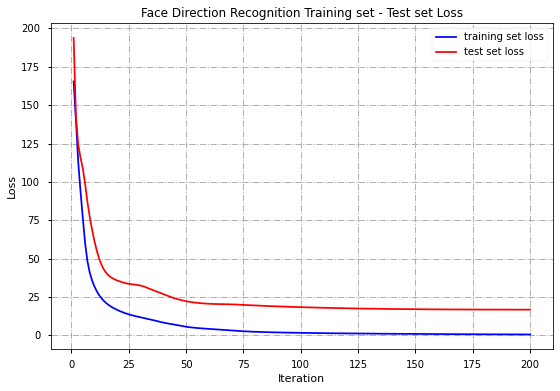

In [151]:
epoch = np.arange(1, len(train_diff_list) + 1, 1) # 步长为1
line1,=plt.plot(epoch, train_diff_list, 'b')
line2,=plt.plot(epoch, test_diff_list,'r')
plt.legend(handles=[line1,line2],labels=['training set loss','test set loss'], loc='best')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('Face Direction Recognition Training set - Test set Loss')
plt.gcf().set_size_inches(9, 6)
plt.grid(linestyle='-.')
plt.show()

此处可以看到训练集已经完全拟合，测试集收敛

In [152]:
train_error_data = train_error_list/train_data_size
test_error_data = test_error_list/test_data_size

In [153]:
train_accuracy_data = 1-train_error_data
test_accuracy_data = 1- test_error_data

In [154]:
print('training set accuracy:',np.max(train_accuracy_data))
print('test set accuracy:',np.max(test_accuracy_data))

training set accuracy: 1.0
test set accuracy: 0.9598765432098766


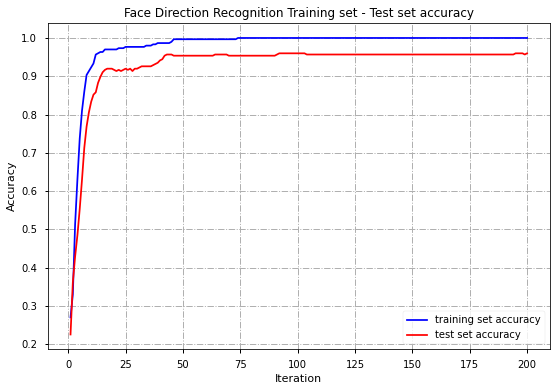

In [155]:
epoch = np.arange(1, len(train_error_data) + 1, 1) # 步长为1
line1,=plt.plot(epoch, train_accuracy_data, 'b')
line2,=plt.plot(epoch, test_accuracy_data,'r')
plt.legend(handles=[line1,line2],labels=['training set accuracy','test set accuracy'], loc='best')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title('Face Direction Recognition Training set - Test set accuracy')
plt.gcf().set_size_inches(9, 6)
plt.grid(linestyle='-.')
plt.show()

In [156]:
clf = cluster.KMeans(init='k-means++', n_clusters=4, random_state=1,max_iter = 2500)
clf.fit(train_data['imgs'])

KMeans(max_iter=2500, n_clusters=4, random_state=1)

In [157]:
print(clf.labels_.shape)

(300,)


In [158]:
y_pred = clf.predict(test_data['imgs'])

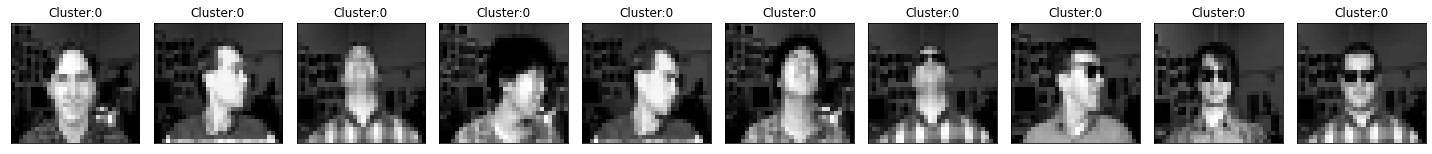

In [159]:
cluster_list_0 = []
cluster_list_1 = []
cluster_list_2 = []
cluster_list_3 = []

# 挑选出编号为1的簇
for i in range(0,324):
    if(y_pred[i]==0):
        cluster_list_0.append(i)
    elif(y_pred[i]==1):
        cluster_list_1.append(i)
    elif(y_pred[i]==2):
        cluster_list_2.append(i)
    else: 
        cluster_list_3.append(i)
    
# cluster_list

plt.figure(figsize=(20,20))
i = 0
for digit_num in cluster_list_0:
    if(i == 10):break # 打印十个样本用于查看
    plt.subplot(10,10,i+1)
    grid_data = test_data['imgs'][digit_num].reshape(30,32)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none",cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    each_title = 'Cluster:'+str(y_pred[digit_num])
    plt.title(each_title)
    i+=1
    
plt.tight_layout()
# plt.title("Kmeans Cluster 1")

可以看到似乎Kmeans这种无监督学习法还是有一定准确度的

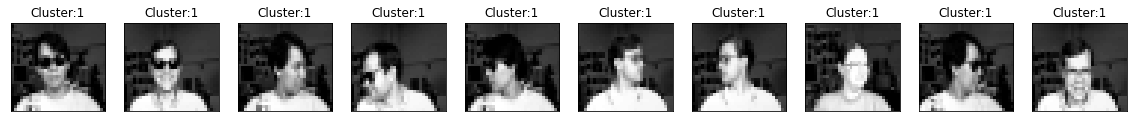

In [160]:
plt.figure(figsize=(20,20))
i = 0
for digit_num in cluster_list_1:
    if(i == 10):break # 打印十个样本用于查看
    plt.subplot(10,10,i+1)
    grid_data = test_data['imgs'][digit_num].reshape(30,32)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none",cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    each_title = 'Cluster:'+str(y_pred[digit_num])
    plt.title(each_title)
    i+=1

In [161]:
test_data_label_raw = test_data['face_smilies']
test_data_label = []

Remark:此处采用了标签平滑

In [162]:
for row in test_data_label_raw: 
    if row[0] == 0.9:
        test_data_label.append(0)
    if row[1] == 0.9:
        test_data_label.append(1)
    if row[2] == 0.9:
        test_data_label.append(2)
    if row[3] == 0.9:
        test_data_label.append(3)

In [163]:
direction_distr_0=[]
direction_distr_1=[]
for num in range(0,4):
    temp_digit_num = 0
    for digit_num in cluster_list_0:
        if(test_data_label[digit_num] == num):temp_digit_num+=1
    direction_distr_0.append(temp_digit_num)
for num in range(0,4):
    temp_digit_num = 0
    for digit_num in cluster_list_1:
        if(test_data_label[digit_num] == num):temp_digit_num+=1
    direction_distr_1.append(temp_digit_num)

下面是对单个簇中的数据分布的可视化，有一定的随机性，但总的来说效果并不是特别好，但介于这是无监督学习，也情有可原

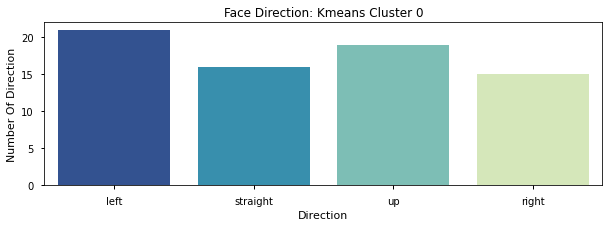

In [164]:
df = pd.DataFrame()
df['Direction'] = DIRECTION
df['Number Of Direction'] =  direction_distr_0
plt.figure(figsize=(10, 3))
# style.use('seaborn-notebook')
plt.title('Face Direction: Kmeans Cluster 0')
p1=sns.barplot( data=df, x='Direction', y='Number Of Direction',palette="YlGnBu_r")
plt.show()

In [165]:
direction_distr_1

[29, 17, 14, 14]

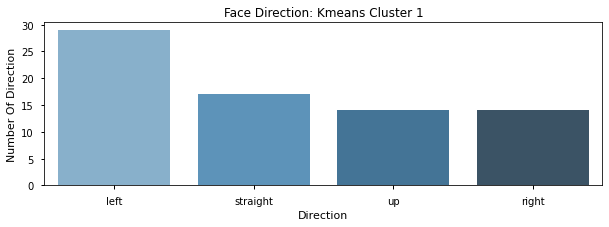

In [166]:
df = pd.DataFrame()
df['Direction'] = DIRECTION
df['Number Of Direction'] =  direction_distr_1
plt.figure(figsize=(10, 3))
# style.use('seaborn-notebook')
plt.title('Face Direction: Kmeans Cluster 1')
p1=sns.barplot( data=df, x='Direction', y='Number Of Direction',palette="Blues_d")
plt.show()

In [167]:
X = train_data['imgs']
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0],
               reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [168]:
pca = PCA(n_components = 2)
pca.fit(train_data['imgs'])
train_data_pca = pca.transform(train_data['imgs'])
test_data_pca = pca.transform(test_data['imgs'])

In [169]:
pca_clf = cluster.KMeans(init='k-means++', n_clusters=10, random_state=42,max_iter = 2500)
# 默认下应该是迭代五百次，五百次其实就可以收敛了
pca_clf.fit(train_data_pca)

KMeans(max_iter=2500, n_clusters=10, random_state=42)

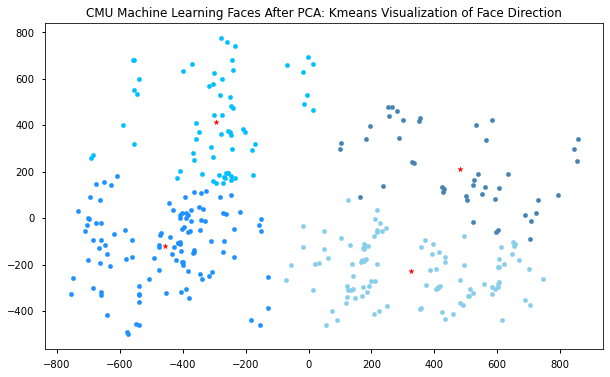

In [170]:
plt.figure(figsize=(10,6))
all_points = []
colors = ['dodgerblue', 'skyblue', 'steelblue', 'deepskyblue']
i = 0 
# 抽一部分数据用于可视化
while i < 324:
    point = [test_data_pca[i][0],test_data_pca[i][1]]
    all_points.append(point)
    i+=1
    
# 调用KMeans方法, 聚类数为10个
kmeans = cluster.KMeans(n_clusters=4).fit(all_points)
plt.title('CMU Machine Learning Faces After PCA: Kmeans Visualization of Face Direction')
centroids = kmeans.cluster_centers_ # kmeans提供了centroids

for id, label in enumerate(kmeans.labels_):
    plt.scatter(all_points[id][0], all_points[id][1], color = colors[label], marker='o', s=20)
    
# 此处应该先把点画上，再画聚类中心，否则会被盖住！
for c in range(0,4):
    plt.scatter(centroids[c][0], centroids[c][1], color = 'red', marker='*',s=30) #五角星为聚类中心

上图为Kmeans的可视化，红色五角星为聚类中心

## 表情识别

In [182]:
img_name_list = get_imgs_path(configs['IMGPATH'])
random.shuffle(img_name_list)
train_data = get_imgs(img_name_list[:300])
test_data = get_imgs(img_name_list[300:])

train_data_size = len(train_data['imgs'])
test_data_size = len(test_data['imgs'])

print('training set size: ' + str(train_data_size))
print('test set size: ' + str(test_data_size))

train_type = 'face_smilies'
result_datas = []

result = train_test(train_data, test_data, train_type, 20, 0.1, 0.1, 150)

result_datas.append(result)

train_diff_smi_list = result['train_diff_vals'] # 训练集损失
train_error_smi_list = result['train_errors_times']
test_diff_smi_list = result['test_diff_vals'] # 测试集损失
test_error_smi_list = result['test_errors_times']
train_errors_smi_rate = 1 - result['train_errors_times'] / train_data_size
test_errors_smi_rate = 1 - result['test_errors_times'] / test_data_size

Direction: ['left', 'straight', 'up', 'right']
Name: ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']
Smilies: ['neutral', 'angry', 'happy', 'sad']
Sunglasses or Not: ['sunglasses', 'open']
training set size: 300
test set size: 324


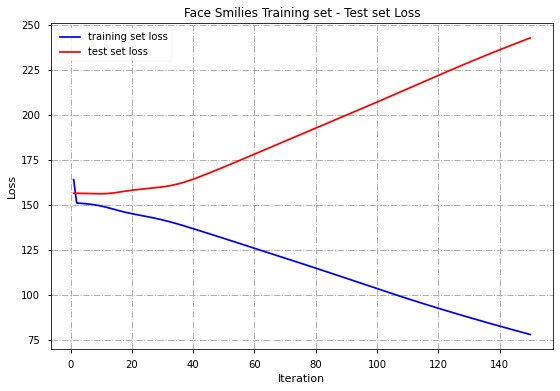

In [183]:
epoch = np.arange(1, len(train_diff_smi_list) + 1, 1) # 步长为1
line1,=plt.plot(epoch, train_diff_smi_list, 'b')
line2,=plt.plot(epoch, test_diff_smi_list,'r')
plt.legend(handles=[line1,line2],labels=['training set loss','test set loss'], loc='best')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('Face Smilies Training set - Test set Loss')
plt.gcf().set_size_inches(9, 6)
plt.grid(linestyle='-.')
plt.show()

表情分类的任务表现并不理想，在报告中有解释

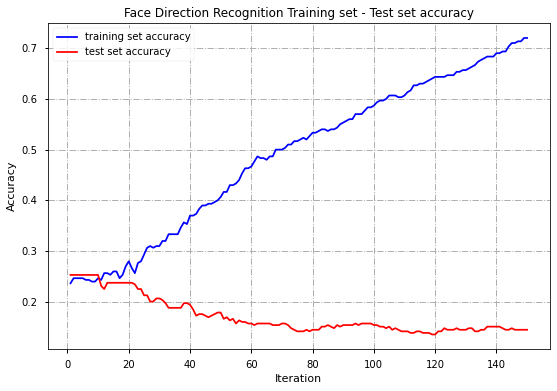

In [184]:
epoch = np.arange(1, len(test_errors_smi_rate) + 1, 1) # 步长为1
line1,=plt.plot(epoch, train_errors_smi_rate, 'b')
line2,=plt.plot(epoch, test_errors_smi_rate,'r')
plt.legend(handles=[line1,line2],labels=['training set accuracy','test set accuracy'], loc='best')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title('Face Direction Recognition Training set - Test set accuracy')
plt.gcf().set_size_inches(9, 6)
plt.grid(linestyle='-.')
plt.show()

该任务表现不理想，同上

In [185]:
train_error_smi_data = train_error_smi_list/train_data_size
test_error_smi_data = test_error_smi_list/test_data_size
train_accuracy_smi_data = 1-train_error_smi_data
test_accuracy_smi_data = 1- test_error_smi_data

In [187]:
print('training set accuracy:',np.max(train_accuracy_smi_data))
print('test set accuracy:',np.max(test_accuracy_smi_data))

training set accuracy: 0.72
test set accuracy: 0.25308641975308643


## 人脸识别

二十分类任务，使用神经网络算法

In [174]:
img_name_list = get_imgs_path(configs['IMGPATH'])
random.shuffle(img_name_list)
train_data = get_imgs(img_name_list[:300])
test_data = get_imgs(img_name_list[300:])

train_data_size = len(train_data['imgs'])
test_data_size = len(test_data['imgs'])

print('training set size: ' + str(train_data_size))
print('test set size: ' + str(test_data_size))

train_type = 'face_name'
result_datas = []
result = train_test(train_data, test_data, train_type, 20, 0.1, 0.1, 100) # 训练轮次100轮就足够了
result_datas.append(result)
train_diff_list = result['train_diff_vals'] # 训练集损失
train_error_list = result['train_errors_times']
test_diff_list = result['test_diff_vals'] # 测试集损失
test_error_list = result['test_errors_times']
train_errors_rate = 1 - result['train_errors_times'] / train_data_size
test_errors_rate = 1 - result['test_errors_times'] / test_data_size

Direction: ['left', 'straight', 'up', 'right']
Name: ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']
Smilies: ['neutral', 'angry', 'happy', 'sad']
Sunglasses or Not: ['sunglasses', 'open']
training set size: 300
test set size: 324


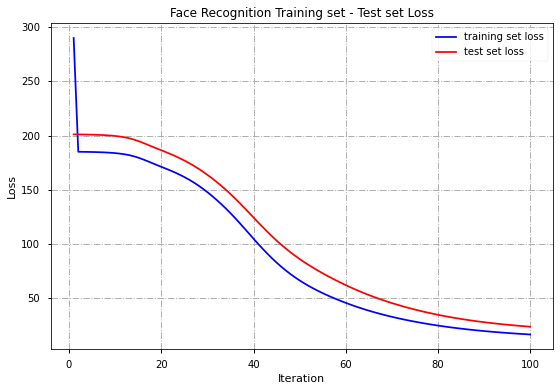

In [175]:
epoch = np.arange(1, len(train_diff_list) + 1, 1) # 步长为1
# acc_list = np.array(acc_list)
line1,=plt.plot(epoch, train_diff_list, 'b')
line2,=plt.plot(epoch, test_diff_list,'r')
plt.legend(handles=[line1,line2],labels=['training set loss','test set loss'], loc='best')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('Face Recognition Training set - Test set Loss')
plt.gcf().set_size_inches(9, 6)
plt.grid(linestyle='-.')
plt.show()

In [176]:
train_error_data = train_error_list/train_data_size
test_error_data = test_error_list/test_data_size
train_accuracy_data = 1-train_error_data
test_accuracy_data = 1- test_error_data

training set accuracy: 1.0
test set accuracy: 0.9969135802469136


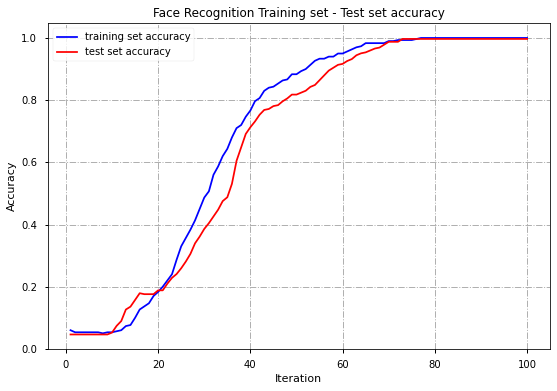

In [177]:
print('training set accuracy:',np.max(train_accuracy_data))
print('test set accuracy:',np.max(test_accuracy_data))
epoch = np.arange(1, len(train_error_data) + 1, 1) # 步长为1
line1,=plt.plot(epoch, train_accuracy_data, 'b')
line2,=plt.plot(epoch, test_accuracy_data,'r')
plt.legend(handles=[line1,line2],labels=['training set accuracy','test set accuracy'], loc='best')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title('Face Recognition Training set - Test set accuracy')
plt.gcf().set_size_inches(9, 6)
plt.grid(linestyle='-.')
plt.show()

人脸识别二十分类任务的表现也很不错

其他指标的可视化直接在训练过程中替换参数字典即可